<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/StockPrediction_withNLP/FineTuneBert_StockNews_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# **Load Kaggle financial news data for training LSTM Sentiment Classifier**

In [318]:
df = pd.read_csv("/content/drive/MyDrive/94812/prediction/all-data.csv", encoding='ISO-8859-1', header=None, names=['sentiment', 'news'])
df

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


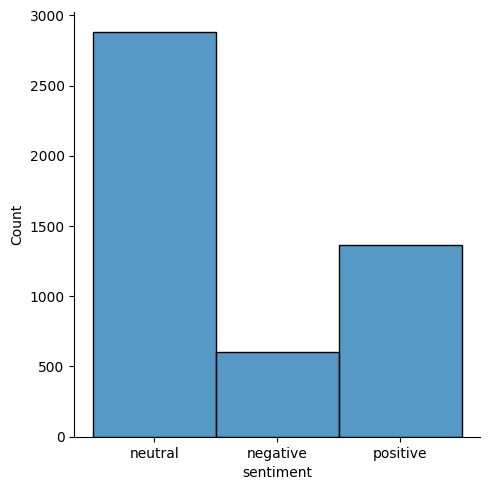

In [319]:
sns.displot(df['sentiment']) #imbalanced data

In [320]:
import pandas as pd
from sklearn.utils import resample

df_0 = df[df['sentiment'] == 'neutral']
df_1 = df[df['sentiment'] == 'negative']
df_2 = df[df['sentiment'] == 'positive']

max_size = max(df_0.shape[0], df_1.shape[0], df_2.shape[0])

df_0_upsampled = resample(df_0, replace=True, n_samples=max_size, random_state=123)
df_1_upsampled = resample(df_1, replace=True, n_samples=max_size, random_state=123)
df_2_upsampled = resample(df_2, replace=True, n_samples=max_size, random_state=123)

df = pd.concat([df_0_upsampled, df_1_upsampled, df_2_upsampled])
df

,sentiment,news
2659,neutral,The order comprises all production lines for a...
2424,neutral,CapMan said the deal 's effect on its cash flo...
3120,neutral,"Simultaneously , Alma Media has purchased a 35..."
3528,neutral,An Apple spokeswoman said the company declined...
2449,neutral,Exel is headquartered in Mantyharju in Finland .
...,...,...
211,positive,"In addition , Kone signed a two-year maintenan..."
1768,positive,Tieto offers Aktia a good foundation and the r...
952,positive,Finnish software developer Basware Oyj said on...
31,positive,The company 's net profit rose 11.4 % on the y...


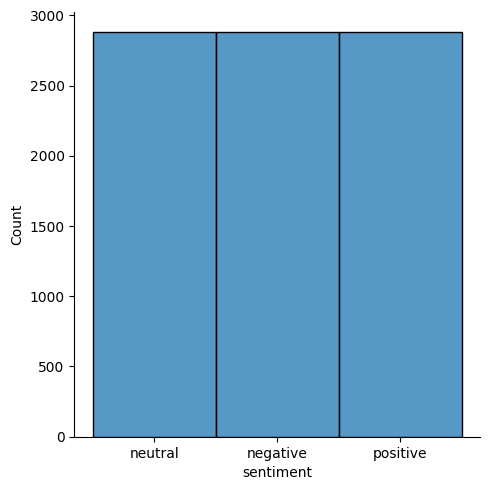

In [347]:
sns.displot(df['sentiment']) #imbalanced data

## **Tokenize**

In [321]:
def to_list(text):
  import re
  pattern = r'\b\w+\b'
  tokens = re.findall(pattern, text.lower())
  return tokens
df['news'] = df['news'].apply(lambda x:x.lower())
df['tokens'] = df['news'].apply(lambda x:to_list(x))
df

,sentiment,news,tokens
2659,neutral,the order comprises all production lines for a...,"[the, order, comprises, all, production, lines..."
2424,neutral,capman said the deal 's effect on its cash flo...,"[capman, said, the, deal, s, effect, on, its, ..."
3120,neutral,"simultaneously , alma media has purchased a 35...","[simultaneously, alma, media, has, purchased, ..."
3528,neutral,an apple spokeswoman said the company declined...,"[an, apple, spokeswoman, said, the, company, d..."
2449,neutral,exel is headquartered in mantyharju in finland .,"[exel, is, headquartered, in, mantyharju, in, ..."
...,...,...,...
211,positive,"in addition , kone signed a two-year maintenan...","[in, addition, kone, signed, a, two, year, mai..."
1768,positive,tieto offers aktia a good foundation and the r...,"[tieto, offers, aktia, a, good, foundation, an..."
952,positive,finnish software developer basware oyj said on...,"[finnish, software, developer, basware, oyj, s..."
31,positive,the company 's net profit rose 11.4 % on the y...,"[the, company, s, net, profit, rose, 11, 4, on..."


Text(0.5, 1.0, 'news token length')

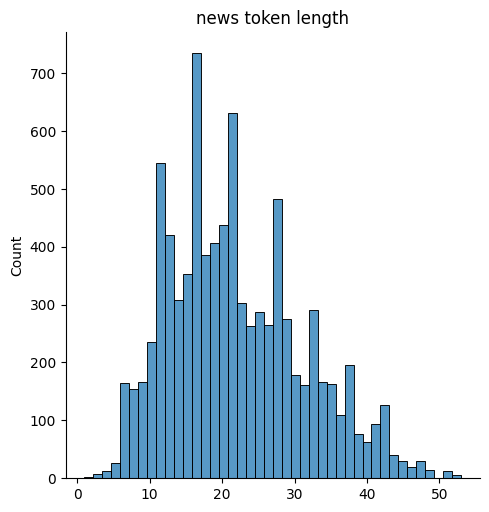

In [348]:
token_length = [len(x) for x in df['tokens']]
sns.displot(token_length)
plt.title("news token length")

In [26]:
# from transformers import AutoModelForSequenceClassification
# from transformers import AutoTokenizer
# model_name = "yiyanghkust/finbert-tone"
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# sentiment_list = ['neutral', 'positive', 'negative']

### **Bert Tokenizer**

In [323]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [324]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [325]:
# Encode text
data = df['news'].apply(lambda x: tokenize(x)).values
print("shape of one news:", data[0]['input_ids'].shape)
data[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  1996,  2344,  8681,  2035,  2537,  3210,  2005,  1037, 20228,
         26985,  4971,  1010,  2194,  2056,  1999,  1037,  4861,  2363,  2011,
          4649, 21572,  2213,  2897,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

## **Sentiment to class indices**

In [326]:
def map_sentiment(x):
  if x=='negative':
    return 2
  elif x=='positive':
    return 1
  else:
    return 0
df['sentiment_score'] = df['sentiment'].apply(map_sentiment)
df

,sentiment,news,tokens,sentiment_score
2659,neutral,the order comprises all production lines for a...,"[the, order, comprises, all, production, lines...",0
2424,neutral,capman said the deal 's effect on its cash flo...,"[capman, said, the, deal, s, effect, on, its, ...",0
3120,neutral,"simultaneously , alma media has purchased a 35...","[simultaneously, alma, media, has, purchased, ...",0
3528,neutral,an apple spokeswoman said the company declined...,"[an, apple, spokeswoman, said, the, company, d...",0
2449,neutral,exel is headquartered in mantyharju in finland .,"[exel, is, headquartered, in, mantyharju, in, ...",0
...,...,...,...,...
211,positive,"in addition , kone signed a two-year maintenan...","[in, addition, kone, signed, a, two, year, mai...",1
1768,positive,tieto offers aktia a good foundation and the r...,"[tieto, offers, aktia, a, good, foundation, an...",1
952,positive,finnish software developer basware oyj said on...,"[finnish, software, developer, basware, oyj, s...",1
31,positive,the company 's net profit rose 11.4 % on the y...,"[the, company, s, net, profit, rose, 11, 4, on...",1


# **Fine Tune Bert**

In [327]:
!pip install -q torchsummaryX
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


## **Dataset & Dataloader**

In [328]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 1e-3,
    'bert_lr':1e-6,
    'epochs': 30,
}

In [329]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data, label) :
        super().__init__()
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        self.label = torch.LongTensor(label)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index]), self.label[index]

In [330]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, df['sentiment_score'].values, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((6909,), (6909,))

In [332]:
train_data = NLPDataset(X_train, y_train)
val_data = NLPDataset(X_test, y_test)
len(train_data), len(val_data)

(6909, 1728)

In [333]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['batch_size'],
    shuffle=False
)

for batch in train_loader:
    X, y=batch
    print("Sample batch shape:", X[0].shape, y.shape, y)
    break

Sample batch shape: torch.Size([64, 50]) torch.Size([64]) tensor([1, 0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 1,
        2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 0, 0,
        2, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1])


## **Bert Model**

In [334]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)


In [335]:
bert = BertModel.from_pretrained("bert-base-uncased").to(device)
model=BERT(bert).to(device)
# print(x.size)
for X, y in train_loader:
    y=y.to(device)
    print("x shape:", X[0].shape, "y shape:", y.shape)
    out=model(X)
    print("out shape:", out.shape)
    summary(model,X)
    break

x shape: torch.Size([64, 50]) y shape: torch.Size([64])
out shape: torch.Size([64, 3])
                                                    Kernel Shape  \
Layer                                                              
0_bert.embeddings.Embedding_word_embeddings         [768, 30522]   
1_bert.embeddings.Embedding_token_type_embeddings       [768, 2]   
2_bert.embeddings.Embedding_position_embeddings       [768, 512]   
3_bert.embeddings.LayerNorm_LayerNorm                      [768]   
4_bert.embeddings.Dropout_dropout                              -   
5_bert.encoder.layer.0.attention.self.Linear_query    [768, 768]   
6_bert.encoder.layer.0.attention.self.Linear_key      [768, 768]   
7_bert.encoder.layer.0.attention.self.Linear_value    [768, 768]   
8_bert.encoder.layer.0.attention.self.Dropout_d...             -   
9_bert.encoder.layer.0.attention.output.Linear_...    [768, 768]   
10_bert.encoder.layer.0.attention.output.Dropou...             -   
11_bert.encoder.layer.0.atten

In [336]:
#fine tuning learning rate group
bert_parameters = [param for name, param in model.named_parameters() if 'bert' in name]
classification_parameters = [param for name, param in model.named_parameters() if 'mlp' in name]
param_groups = [
    {'params': classification_parameters, 'lr': config['lr']},
    {'params': bert_parameters, 'lr': config['bert_lr']}
]

In [337]:
optimizer   = torch.optim.AdamW(param_groups, weight_decay = 1e-3)
criterion   = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)
print("loss:", criterion(out, y))

loss: tensor(1.0997, device='cuda:0', grad_fn=<AddBackward0>)


## **Train & Val functions**

In [338]:
def train():
      model.train() # set to training mode
      model.to(device)
      train_plot=[]

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()
          X, y = batch

          X= X
          y = y.to(device)
          y_pred = model(X).squeeze()

          loss = criterion(y_pred, y)    #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          train_plot.append(loss.item())
          total_loss += loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              num_correct = num_correct,
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()


          del X,y
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / y_train.shape[0]
      total_loss  = float(total_loss / len(train_loader))

      return acc, total_loss

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          X, y = batch

          X= X
          y = y.to(device)
          y_pred = model(X).squeeze()

          val_loss = criterion(y_pred, y)    #TODO: try changing 8 to others, if want the model to learn other columns

          total_loss += val_loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              num_correct = num_correct
               )
          batch_bar.update()

          del X,y
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / y_test.shape[0]
      total_loss  = float(total_loss / len(val_loader))

      return acc, total_loss



## **Train Loop**

In [339]:
# optimizer.param_groups[0]['lr']=1e-3
train_acc_plot=[]
train_loss_plot=[]
val_acc_plot=[]
val_loss_plot=[]
num_epochs=30
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    bert_lr = float(optimizer.param_groups[1]['lr'])


    train_acc, train_loss            = train()
    train_loss_plot.append(train_loss)
    train_acc_plot.append(train_acc)
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.08f} Bert Learning Rate {:.08f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr,
        bert_lr))

    val_acc, val_loss                = validate()
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    scheduler.step()
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))



Epoch: 1/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 1/30: 
Train Acc 50.9625%	 Train Loss 0.9776	 Learning Rate 0.00100000 Bert Learning Rate 0.00000100


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 62.5000%	 Val Loss 0.8560

Epoch: 2/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 2/30: 
Train Acc 68.1430%	 Train Loss 0.7893	 Learning Rate 0.00085000 Bert Learning Rate 0.00000085


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 77.5463%	 Val Loss 0.6715

Epoch: 3/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 3/30: 
Train Acc 78.1010%	 Train Loss 0.6616	 Learning Rate 0.00072250 Bert Learning Rate 0.00000072


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 82.0602%	 Val Loss 0.6135

Epoch: 4/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 4/30: 
Train Acc 81.0248%	 Train Loss 0.6115	 Learning Rate 0.00061412 Bert Learning Rate 0.00000061


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 81.5394%	 Val Loss 0.5981

Epoch: 5/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 5/30: 
Train Acc 82.9932%	 Train Loss 0.5873	 Learning Rate 0.00052201 Bert Learning Rate 0.00000052


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 83.7963%	 Val Loss 0.5724

Epoch: 6/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 6/30: 
Train Acc 84.9761%	 Train Loss 0.5515	 Learning Rate 0.00044371 Bert Learning Rate 0.00000044


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 86.3426%	 Val Loss 0.5297

Epoch: 7/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 7/30: 
Train Acc 85.5840%	 Train Loss 0.5393	 Learning Rate 0.00037715 Bert Learning Rate 0.00000038


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 86.6898%	 Val Loss 0.5283

Epoch: 8/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 8/30: 
Train Acc 86.6840%	 Train Loss 0.5254	 Learning Rate 0.00032058 Bert Learning Rate 0.00000032


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 87.8472%	 Val Loss 0.5141

Epoch: 9/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 9/30: 
Train Acc 86.7564%	 Train Loss 0.5192	 Learning Rate 0.00027249 Bert Learning Rate 0.00000027


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 88.1944%	 Val Loss 0.5033

Epoch: 10/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 10/30: 
Train Acc 87.9867%	 Train Loss 0.5094	 Learning Rate 0.00023162 Bert Learning Rate 0.00000023


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 88.5417%	 Val Loss 0.4982

Epoch: 11/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 11/30: 
Train Acc 87.9722%	 Train Loss 0.5009	 Learning Rate 0.00019687 Bert Learning Rate 0.00000020


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 88.3102%	 Val Loss 0.4993

Epoch: 12/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 12/30: 
Train Acc 88.6814%	 Train Loss 0.4923	 Learning Rate 0.00016734 Bert Learning Rate 0.00000017


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 88.6574%	 Val Loss 0.4926

Epoch: 13/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 13/30: 
Train Acc 88.7249%	 Train Loss 0.4913	 Learning Rate 0.00014224 Bert Learning Rate 0.00000014


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 89.8727%	 Val Loss 0.4829

Epoch: 14/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 14/30: 
Train Acc 89.2314%	 Train Loss 0.4851	 Learning Rate 0.00012091 Bert Learning Rate 0.00000012


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 89.8148%	 Val Loss 0.4815

Epoch: 15/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 15/30: 
Train Acc 88.9999%	 Train Loss 0.4839	 Learning Rate 0.00010277 Bert Learning Rate 0.00000010


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.1620%	 Val Loss 0.4776

Epoch: 16/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 16/30: 
Train Acc 89.4051%	 Train Loss 0.4809	 Learning Rate 0.00008735 Bert Learning Rate 0.00000009


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 89.4676%	 Val Loss 0.4830

Epoch: 17/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 17/30: 
Train Acc 89.9551%	 Train Loss 0.4726	 Learning Rate 0.00007425 Bert Learning Rate 0.00000007


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 89.8148%	 Val Loss 0.4801

Epoch: 18/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 18/30: 
Train Acc 89.7235%	 Train Loss 0.4758	 Learning Rate 0.00006311 Bert Learning Rate 0.00000006


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.0463%	 Val Loss 0.4773

Epoch: 19/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 19/30: 
Train Acc 89.7959%	 Train Loss 0.4731	 Learning Rate 0.00005365 Bert Learning Rate 0.00000005


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.4514%	 Val Loss 0.4710

Epoch: 20/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 20/30: 
Train Acc 89.8249%	 Train Loss 0.4767	 Learning Rate 0.00004560 Bert Learning Rate 0.00000005


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5671%	 Val Loss 0.4722

Epoch: 21/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 21/30: 
Train Acc 89.7380%	 Train Loss 0.4724	 Learning Rate 0.00003876 Bert Learning Rate 0.00000004


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5671%	 Val Loss 0.4703

Epoch: 22/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 22/30: 
Train Acc 90.4617%	 Train Loss 0.4703	 Learning Rate 0.00003295 Bert Learning Rate 0.00000003


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5093%	 Val Loss 0.4722

Epoch: 23/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 23/30: 
Train Acc 90.5775%	 Train Loss 0.4652	 Learning Rate 0.00002800 Bert Learning Rate 0.00000003


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.6829%	 Val Loss 0.4714

Epoch: 24/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 24/30: 
Train Acc 90.2301%	 Train Loss 0.4678	 Learning Rate 0.00002380 Bert Learning Rate 0.00000002


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5093%	 Val Loss 0.4702

Epoch: 25/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 25/30: 
Train Acc 90.3170%	 Train Loss 0.4683	 Learning Rate 0.00002023 Bert Learning Rate 0.00000002


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.3935%	 Val Loss 0.4715

Epoch: 26/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 26/30: 
Train Acc 90.2880%	 Train Loss 0.4669	 Learning Rate 0.00001720 Bert Learning Rate 0.00000002


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.7986%	 Val Loss 0.4683

Epoch: 27/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 27/30: 
Train Acc 90.1722%	 Train Loss 0.4695	 Learning Rate 0.00001462 Bert Learning Rate 0.00000001


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5093%	 Val Loss 0.4713

Epoch: 28/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 28/30: 
Train Acc 90.3315%	 Train Loss 0.4663	 Learning Rate 0.00001243 Bert Learning Rate 0.00000001


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.5671%	 Val Loss 0.4692

Epoch: 29/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 29/30: 
Train Acc 90.3604%	 Train Loss 0.4655	 Learning Rate 0.00001056 Bert Learning Rate 0.00000001


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.6250%	 Val Loss 0.4692

Epoch: 30/30


Train:   0%|          | 0/108 [00:00<?, ?it/s]


Epoch 30/30: 
Train Acc 90.2591%	 Train Loss 0.4681	 Learning Rate 0.00000898 Bert Learning Rate 0.00000001


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Val Acc 90.6250%	 Val Loss 0.4689


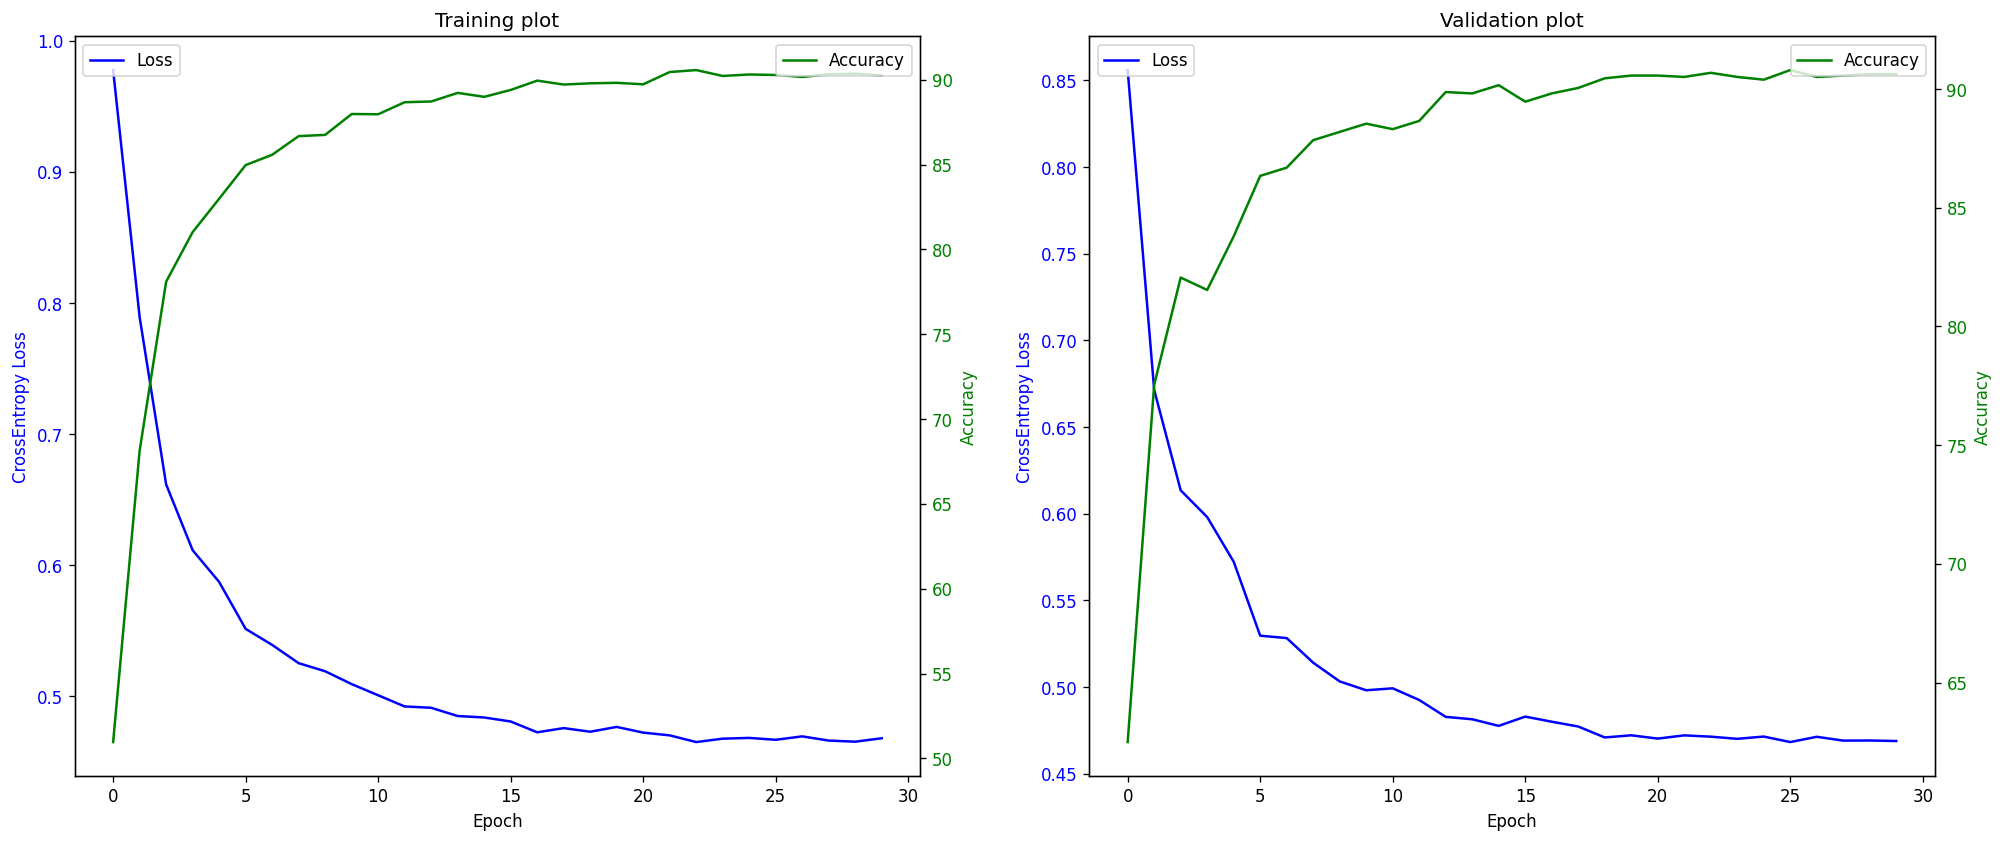

In [340]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_loss_plot, label='Loss', color='blue')
ax1.set_ylabel("CrossEntropy Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax2 = ax1.twinx()
ax2.plot(train_acc_plot, label='Accuracy', color='green')
ax2.set_ylabel("Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Validation Plot
ax3 = ax[1]
ax3.plot(val_loss_plot, label='Loss', color='blue')
ax3.set_ylabel("CrossEntropy Loss", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax4 = ax3.twinx()
ax4.plot(val_acc_plot, label='Accuracy', color='green')
ax4.set_ylabel("Accuracy", color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

plt.show()

In [341]:
torch.save(model, "/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")

In [373]:
text = "The company is doing so freaking bad, it's bankrupting"
tok = list(tokenize(text).values())

senti = model(tok)
print("prediction",senti)

senti_list = ['neutral', 'positive', 'negative']
print(senti_list[int(senti.argmax())])

prediction tensor([[ 0.4435, -1.8166,  1.4181]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
negative


## **Reddit API**

In [ ]:
!pip install praw -q

In [388]:
import praw

reddit = praw.Reddit(
    client_id='ZkUXC1KYZEuu-Iq2mMIdpQ',
    client_secret='ueI6Ou7Wvs1vzAOWgAapSMUdzGCThg',
    password='Xie19970826',
    user_agent='script by /u/SeaCartographer5113',
    username='SeaCartographer5113',
)

In [427]:
import datetime as dt

# Define the subreddit and search query
subreddit = reddit.subreddit('wallstreetbets')  # For example, use 'wallstreetbets'
# subreddit = reddit.subreddit('stocks')
query = 'GameStop'

# Define the time period
start_epoch = int(dt.datetime(2020, 1, 1).timestamp())
end_epoch = int(dt.datetime(2022, 3, 1).timestamp())

df_reddit =[]
# Search for submissions in the defined time period
for submission in subreddit.search(query, sort='old', time_filter='all'):
    t = submission.created_utc
    # print(t)
    if start_epoch <= int(t) <= end_epoch:
      # print(f"Text: {submission.selftext}")
      # print(submission.title, submission.url)
      title = submission.title
      post_date = dt.datetime.fromtimestamp(submission.created_utc)
      # print(f"Submission Date: {post_date}")
      df_reddit.append([post_date, title])

      # Additional code to scrape comments, etc.
df_reddit=pd.DataFrame(df_reddit, columns = ['date', 'title']).sort_values('date').drop_duplicates().reset_index(drop=True)
df_reddit

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,date,title
0,2020-09-19 13:03:54,Bankrupting Institutional Investors for Dummie...
1,2020-11-23 16:23:50,GameStop Maguire
2,2020-12-14 15:58:01,GameStop is out with a new logo
3,2021-01-11 12:34:40,GameStop Announces Additional Board Refreshmen...
4,2021-01-18 16:00:04,GameStop Monday Notes - The Rocket is fueling ...
...,...,...
74,2021-11-23 02:59:57,$138K GameStop (GME) Gain
75,2021-11-23 18:10:57,GameStop Stock: Major Catalysts In Sight Again
76,2021-12-08 21:06:48,GME | GameStop Reports Financial Results for Q...
77,2021-12-14 12:03:58,Can’t be the only one loading up on GameStop t...


In [403]:
start_epoch

1609459200

In [428]:
end_epoch = int(dt.datetime(2022, 1, 31).timestamp())
end_epoch

1643587200

In [431]:
import requests

# Example URL for Pushshift API
url = 'https://api.pushshift.io/reddit/search/submission/'
params = {
    'q': 'GME',
    'subreddit': 'stocks',
    'after': '1609459200',  # Start epoch (Jan 1, 2021)
    'before': '1643587200',  # End epoch (Jan 31, 2021)
    'size': 500  # Number of results to return (max 500 per request)
}

response = requests.get(url, params=params)
data = response.json()

# Process data
for submission in data:
  print(submission.title)
    # Your processing logic

<built-in method title of str object at 0x7b2ca34e4ab0>


In [432]:
data

{'detail': 'Not authenticated'}